In [2]:
%pylab inline
%matplotlib inline
import pandas as pd
import numpy as np

from collections import Counter
import re
from lxml import etree 
from bz2file import BZ2File
import codecs
import nltk
import pickle
import seaborn as sns
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt



Populating the interactive namespace from numpy and matplotlib


# JoepTube

### *Joep Straatman, Hidde de Haan, Arjan van Rossum en Bozana Miletic*

<img src='YTLogo_old_new_animation.0.gif'/>

## Onderzoeksvraag:
   *Wat is de invloed van tags onder YouTube video’s op de populariteit van deze video’s?*

### Deelvragen:

* In hoeverre is er een verband tussen het aantal tags en het aantal views?
* In hoeverre is er een verband tussen het aantal tags en de tijd waarin een video trending wordt?
* Komen video’s vaker in de trending-lijst als de video meer tags heeft?
* Hoeveel procent van de tags komen niet voor in de titel, descriptie of gebruikersnaam?



## Gerelateerd werk

* Enrichment and Ranking of the YouTube Tag Space and Integration with the Linked Data Cloud Choudhury et al. (2009) 

* Tagging Video: Conventions and Strategies of the YouTube Community Geisler en Burns (2007) 

* On the Dynamics of Social Media Popularity: A YouTube Case Study Figueiredo et al. (2014)

* Discriminative Tag Learning on YouTube Videos with Latent Sub-tags  Yang en Toderici (2011)





## Methode

In [3]:
us_videosbasic = pd.read_csv("USvideos1.csv")
us_videosbasic.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
us_videos = pd.read_csv("USvideos1.csv")
listje= {1:'Film & Animation ',2:'Autos & Vehicles',10:'Music',15:'Pets & Animals',17:'Sports',18:'Short Movies',19:'Travel & Events',20:'Gaming',21:'Videoblogging',22:'People & Blogs',23:'Comedy',24:'Entertainment',25:'News & Politics',26:'Howto & Style',27:'Education',28:'Science & Technology',29:'Nonprofits & Activism',30:'Movies',31:'Anime/Animation',32:'Action/Adventure',33:'Classics',34:'Comedy',35:'Documentary',36:'Drama',37:'Family',38:'Foreign',39:'Horror',40:'Sci-Fi/Fantasy',41:'Thriller',42:'Shorts',43:'Shows',44:'Trailers'}
us_videos['category'] = us_videos['category_id']
us_videos['category'].replace(listje, inplace=True)

us_videos["tagssplitted"] = us_videos.tags.str.split('|')
us_videos["number_of_tags"] = us_videos['tagssplitted'].str.len()
us_videos["average_tag_length"] = us_videos.tags.str.len() / us_videos.number_of_tags

publishlist = us_videos.publish_time.tolist()
publishdatelist = {}
counter = 0
for item in publishlist:
    year = item[2:4]
    month = item[5:7]
    day = item[8:10]
    date = str.join('.', (year,day,month))
    publishdatelist[counter] = date
    counter +=1

publish = pd.DataFrame.from_dict(publishdatelist, orient='index')
publish.columns = ['publish_date']

df = pd.concat([us_videos, publish], axis=1)
df = df.drop(['thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed'],axis=1)
df['title_occurence'] =  df.groupby(['channel_title'])['channel_title'].transform('count')

from datetime import datetime
from dateutil.parser import parse

pubdate1 = [x.replace(".", "-") for x in df.publish_date]
pubdate2 = [('20'+ x) for x in pubdate1]
pubdate = [datetime.strptime(x, '%Y-%d-%m') for x in pubdate2]

trendate1 = [x.replace(".", "-") for x in df.trending_date]
trendate2 = [('20'+ x) for x in trendate1]
trendate = [datetime.strptime(x, '%Y-%d-%m') for x in trendate2]

differance = []
for x in range(len(trendate)):
    differance.append((trendate[x] - pubdate[x]).days)

df['time_to_trending'] = differance

In [16]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description,category,tagssplitted,number_of_tags,average_tag_length,publish_date,title_occurence,time_to_trending
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,[SHANtell martin],1,15.000000,17.13.11,66,1
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,"One year after the presidential election, John...",Entertainment,"[last week tonight trump presidency, ""last wee...",4,25.500000,17.13.11,24,1
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",23,13.652174,17.12.11,39,2
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,Today we find out if Link is a Nickelback amat...,Entertainment,"[rhett and link, ""gmm"", ""good mythical morning...",27,17.666667,17.13.11,78,1
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,I know it's been a while since we did this sho...,Entertainment,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",14,8.571429,17.12.11,35,2


In [5]:
import matplotlib.gridspec as gridspec
matrix_corr = df.loc[:,['views', 'likes', 'dislikes', 'comment_count', 'title_occurence','number_of_tags']].corr()


masking = np.zeros_like(matrix_corr, dtype=np.bool)
masking[np.triu_indices_from(masking)] = True

Text(0.5,1,'Matrix')

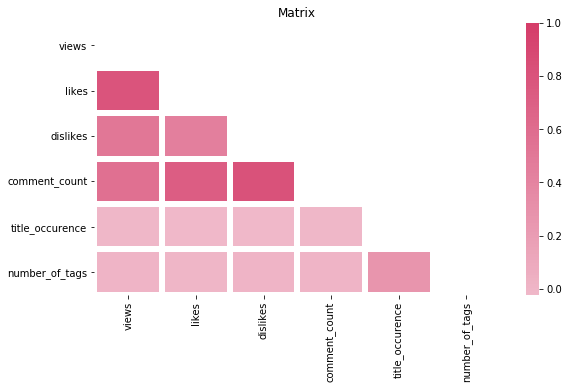

In [7]:
fig = plt.figure(figsize=(20, 5))
grid_spec = gridspec.GridSpec(1, 2, width_ratios=[5,5])
cmap = sns.diverging_palette(0, 0, as_cmap=True)
correlation_fig = plt.subplot(grid_spec[0,0])
correlation_fig = sns.heatmap(matrix_corr, cmap=cmap, center=-0.5,
            linewidths=5, mask=masking)

correlation_fig.set_title('Matrix')

(-0.5, 999.5, 499.5, -0.5)

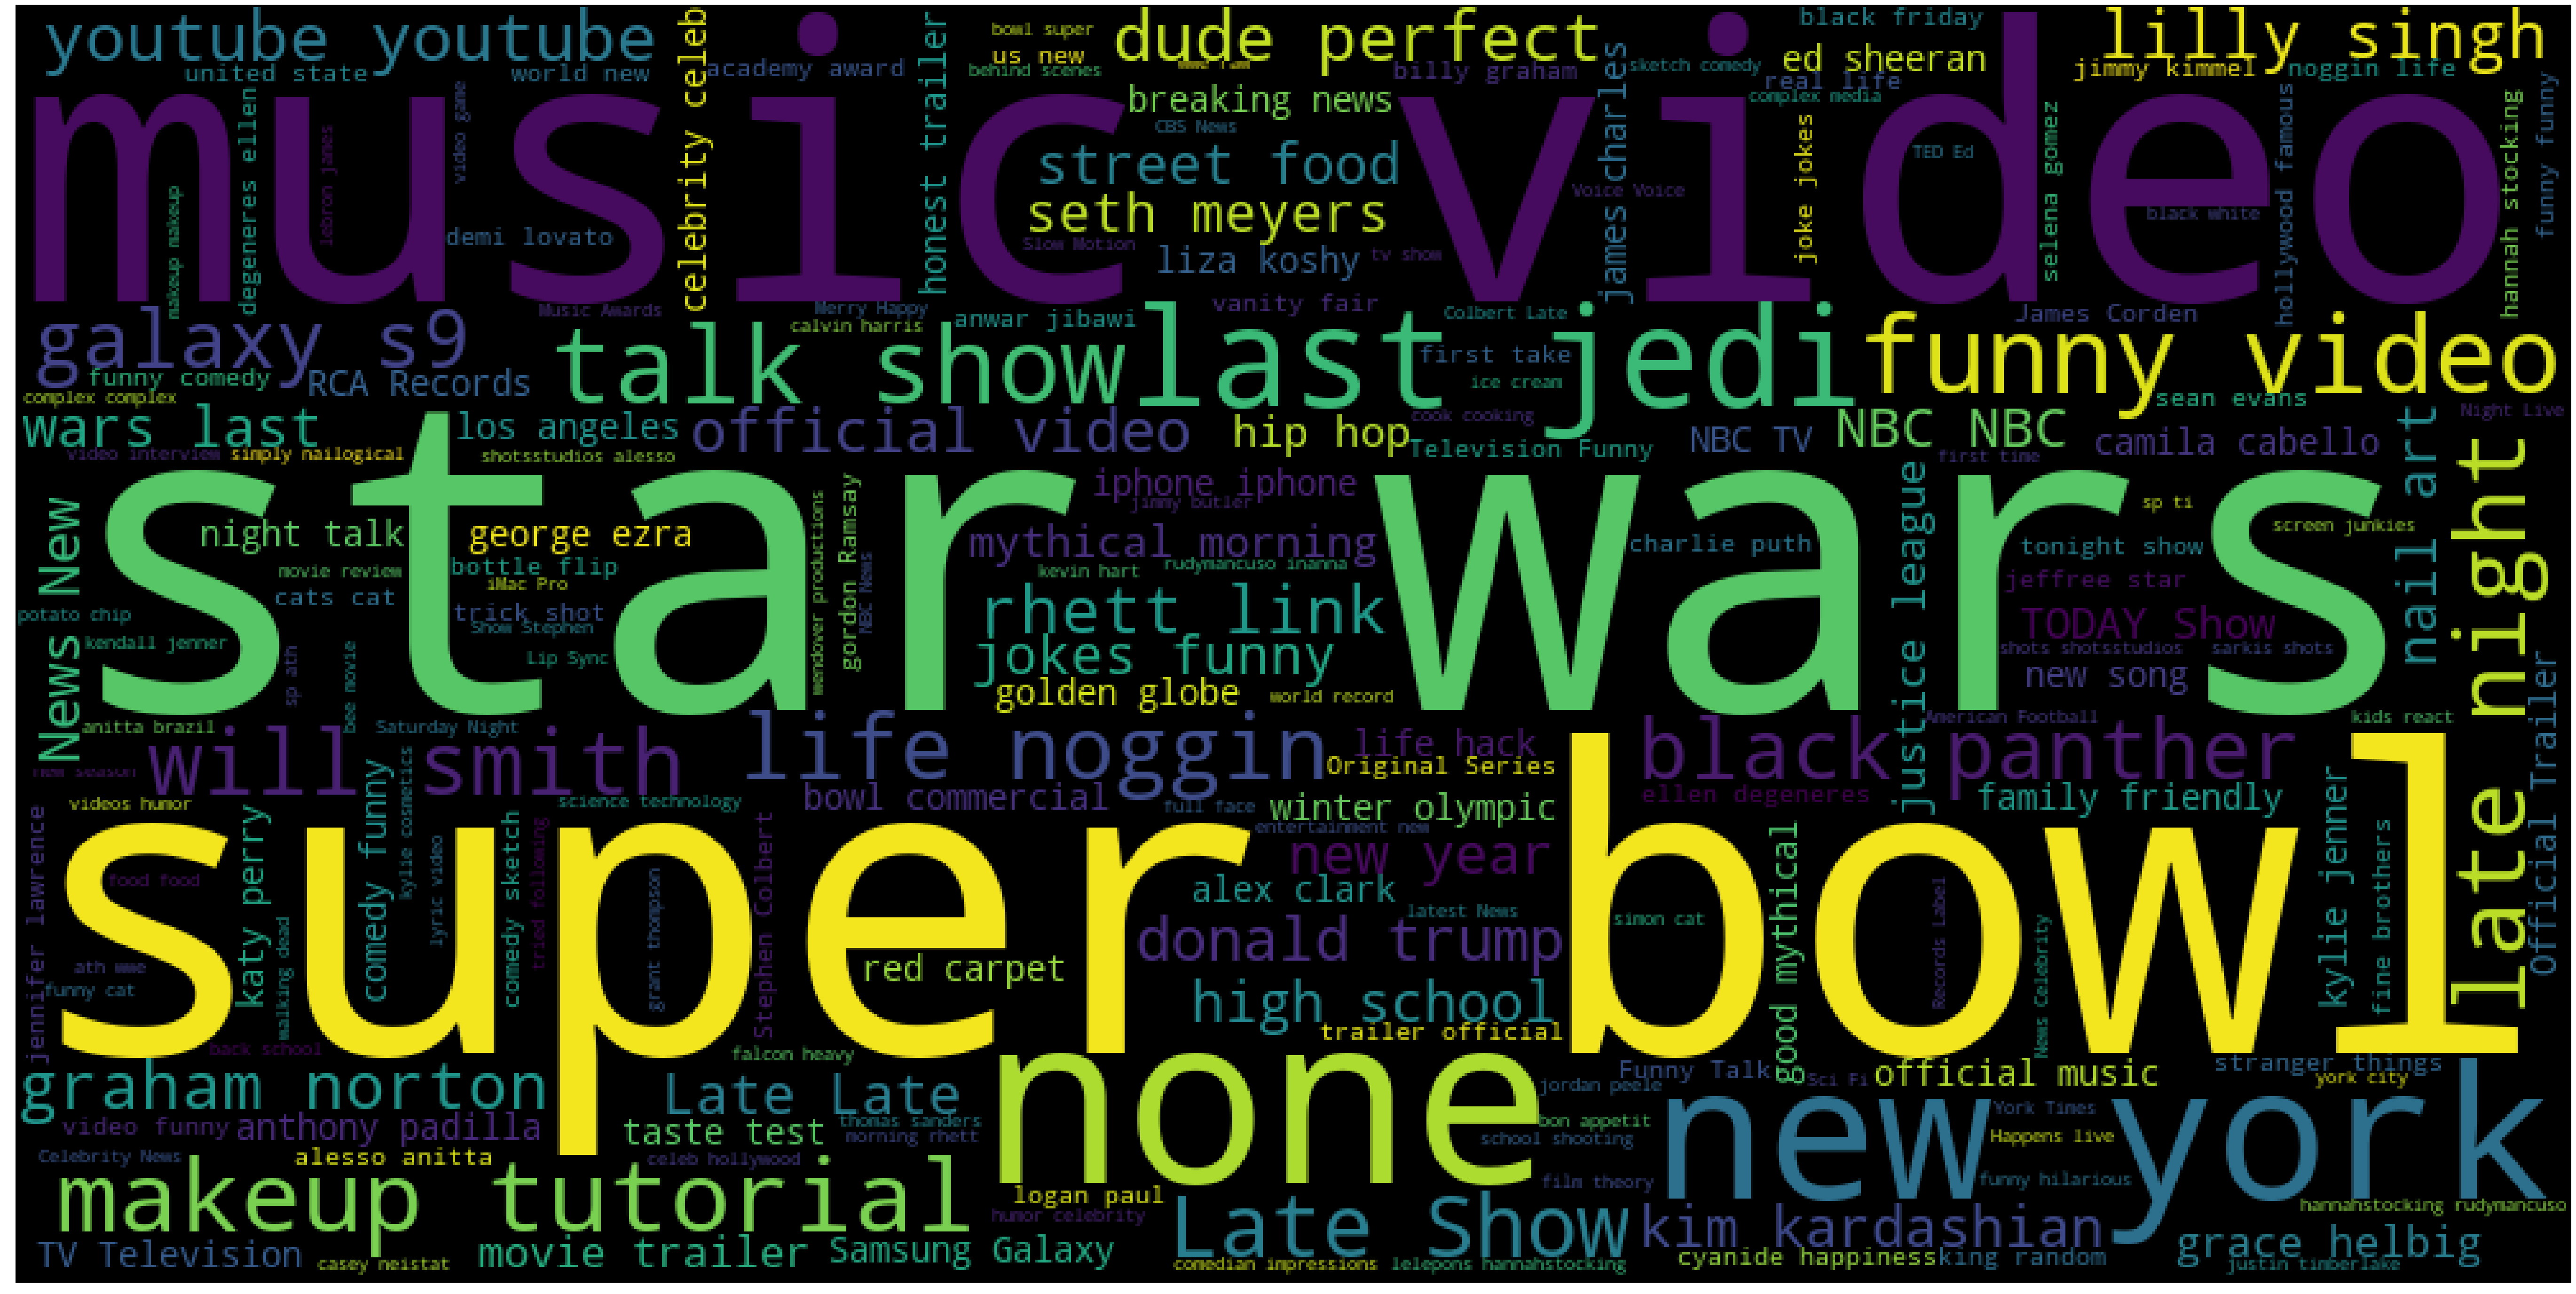

In [32]:
k= (' '.join(df['tags']))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(150,50))
plt.imshow(wordcloud)
plt.axis('off')

In [8]:
def form_hist(given_list,top_n):
    """
    Returns a sorted histogram dataframe (with top_n rows) for a given list.
    """
    item_set = set(given_list)
    items = []
    counts = []
    for nm in item_set:
        items.append(nm)
        counts.append(given_list.count(nm))
    return pd.DataFrame({'count':counts,'items':items}).sort_values(by='count',ascending=False).head(top_n)

def create_hist(videos, num, title):
    """
    Plots our histogram
    """
    all_tags = videos['tags'].map(lambda k: k.lower().split('|')).values
    all_tags = [item for sublist in all_tags for item in sublist]

    counts = form_hist(all_tags,num)
    counts.columns = ['count','tags']
    plt.figure()
    sns.barplot(x = counts['tags'], y = counts['count'])
    plt.xticks(rotation=90)
    plt.ylabel('count')
    plt.title(title)



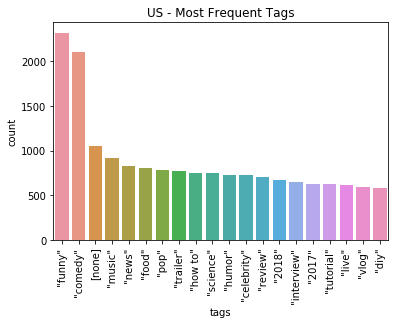

In [9]:
create_hist(df,20,'US - Most Frequent Tags')

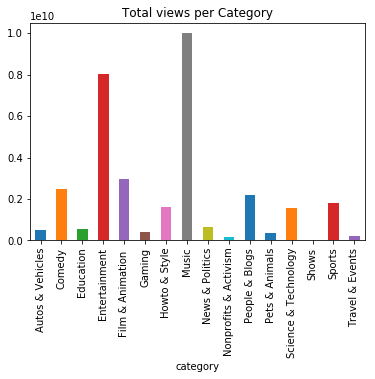

In [10]:
df.groupby('category').views.sum().plot(kind="bar")
plt.title("Total views per Category")
plt.show()

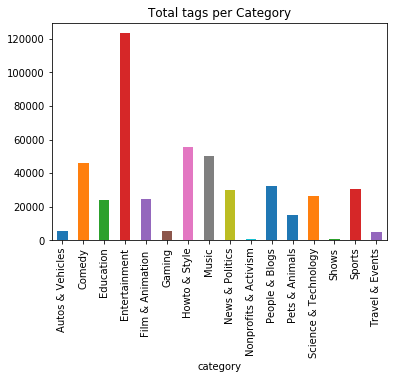

In [11]:
df.groupby('category').number_of_tags.sum().plot(kind="bar")
plt.title("Total tags per Category")
plt.show()

In [12]:
us_videos["tagssplitted"] = us_videos.tags.str.split('|')
us_videos["number_of_tags"] = us_videos['tagssplitted'].str.len()
us_videos["average_tag_length"] = us_videos.tags.str.len() / us_videos.number_of_tags

test = us_videos["dislikes"] > us_videos["likes"]
len (test[test == True])


519

0.012700875995521338

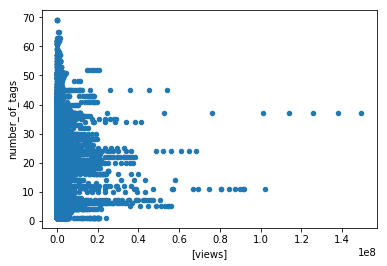

In [13]:
us_videos.plot(y="number_of_tags", x=["views"], kind="scatter")
us_videos['number_of_tags'].corr(us_videos['views'])

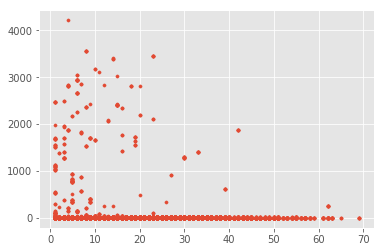

In [20]:
import matplotlib.pyplot as plt
x = df['number_of_tags'].tolist()
y = df['time_to_trending'].tolist()
plt.style.use('ggplot')
plt.scatter(x, y, s=10)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

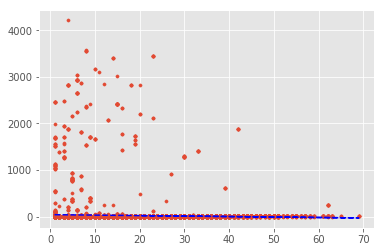

-0.066059958419457457

In [36]:
x = df['number_of_tags'].tolist()
y = df['time_to_trending'].tolist()
plt.style.use('ggplot')
plt.scatter(x, y, s=10)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

plt.show()

df['number_of_tags'].corr(df['time_to_trending'])

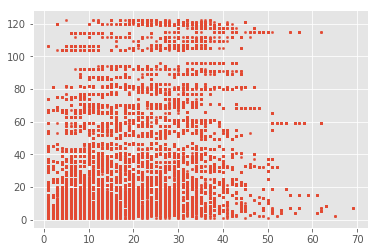

In [22]:

import matplotlib.pyplot as plt
x = df['number_of_tags'].tolist()
y = df['title_occurence'].tolist()
plt.style.use('ggplot')
plt.scatter(x, y, s=5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

In [8]:
x = df['number_of_tags'].tolist()
y = df['title_occurence'].tolist()


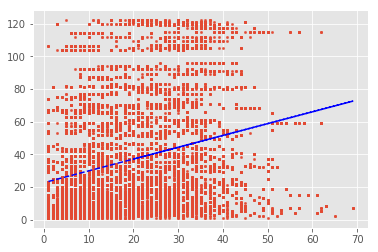

0.26731323888149722

In [9]:
plt.style.use('ggplot')
plt.scatter(x, y, s=5)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

plt.show()

df['number_of_tags'].corr(df['title_occurence'])

In [24]:
distinctlijst = df['tagssplitted'].tolist()
sumtags = 0
indexlijst = df.index.tolist()
number = 0
for x in range(len(distinctlijst)):
    for naam in distinctlijst[x]:
        naam = naam.replace('"', '')
        if naam not in str(df.loc[x, 'title']).lower() and naam not in str(df.loc[x,'description']).lower() and naam not in str(df.loc[x,'channel_title']).lower():
            number += 1
num = df['number_of_tags'].sum()
print (number / num * 100 , '%')

74.7897680481 %


# Conclusie

## Onderzoeksvraag:
   *Wat is de invloed van tags onder YouTube video’s op de populariteit van deze video’s?*

### Deelvragen:

* In hoeverre is er een verband tussen het aantal tags en het aantal views?

*Geen verband* 

* In hoeverre is er een verband tussen het aantal tags en de tijd waarin een video trending wordt?

*Geen verband*

* Komen video’s vaker in de trending-lijst als de video meer tags heeft?

*Klein verband (0.26)*

* Uit onderzoek dat 66% van de tags niet in de titel, description of gebruikersnaam voorkomen. Klopt dit?

*Ja, uit ons onderzoek wel 75%* 



# Bedankt voor jullie aandacht!

<img src='doggo.gif'/>